In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Total Gambar:  1299
Total Label:  20


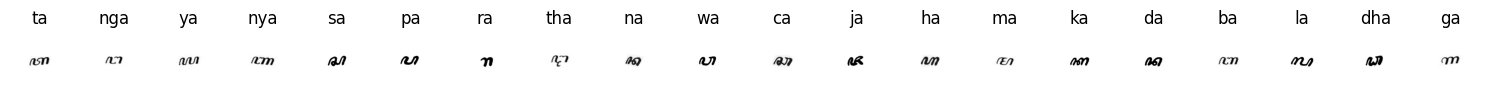

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = []
labels = []
label_to_images = {}

# direktori dataset
data_dir = '/content/gdrive/MyDrive/testing'

# Periksa apakah direktori dataset ada
if not os.path.exists(data_dir):
    print(f"Error: Direktori {data_dir} tidak ditemukan.")
else:
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        # Periksa apakah label_dir adalah direktori
        if os.path.isdir(label_dir):
            label_images = []
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                # Periksa apakah file adalah file gambar yang didukung
                if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image = cv2.imread(image_path)
                    if image is not None:
                        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image_rgb)
                        labels.append(label)
                        label_images.append(image_rgb)
                    else:
                        print(f"Warning: Gambar {image_path} tidak bisa dimuat.")
            label_to_images[label] = label_images

    total_images = len(images)
    total_unique_labels = len(label_to_images)

    print("Total Gambar: ", total_images)
    print("Total Label: ", total_unique_labels)

    # Periksa apakah ada label unik sebelum plotting
    if total_unique_labels > 0:
        fig, axes = plt.subplots(1, total_unique_labels, figsize=(15, 5))

        # Jika hanya ada satu label unik, axes adalah satu AxesSubplot, bukan array
        if total_unique_labels == 1:
            axes = [axes]

        # Plot images
        for i, (label, label_images) in enumerate(label_to_images.items()):
            axes[i].imshow(label_images[0])
            axes[i].set_title(label)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada label unik yang ditemukan.")

Pra Pemrosesan Citra

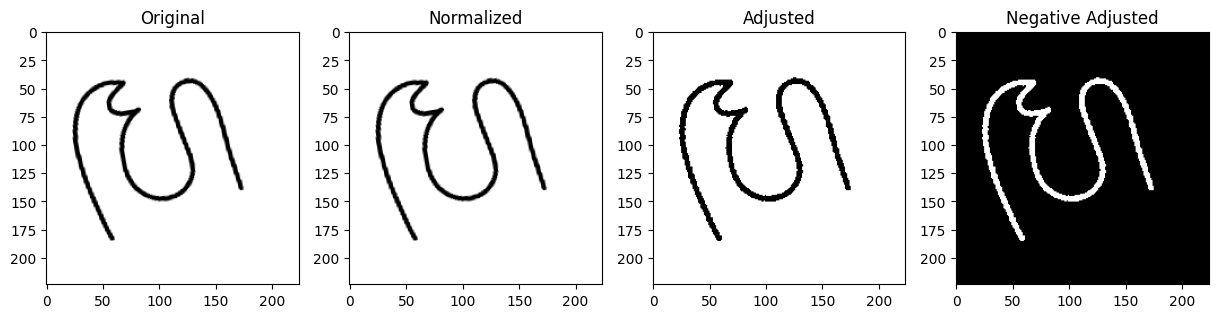

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Asumsikan 'images' adalah array atau daftar yang berisi citra yang akan diproses
# Tambahkan baris ini untuk memastikan 'images' ada
# Misalnya: images = [cv2.imread(image_path) for image_path in image_paths]

def preprocess_image(image):
    # Normalized image
    normalized_image = image.astype(np.float32) / 255.0

    threshold = 0.87

    # Mengganti nilai di atas threshold menjadi putih dan di bawah threshold menjadi hitam
    adjusted_image_array = np.where(normalized_image > threshold, 1.0, 0.0)

    # Membuat gambar negatif
    negative_adjusted_image = 1.0 - adjusted_image_array

    # Pastikan nilai negatif terklip untuk menghindari masalah dengan imshow
    negative_adjusted_image = np.clip(negative_adjusted_image, 0.0, 1.0)

    # Konversi kembali gambar negatif ke uint8
    negative_adjusted_image = (negative_adjusted_image * 255).astype(np.uint8)

    return normalized_image, adjusted_image_array, negative_adjusted_image

# Memilih satu contoh citra dari data yang diproses
sample_image_index = 600 # ganti dengan indeks citra yang ingin anda gunakan
sample_image_data = (images[sample_image_index], *preprocess_image(images[sample_image_index]))

# Menampilkan contoh citra pada seluruh tahapan pra pemrosesan
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(sample_image_data[0], cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[1].imshow(sample_image_data[1], cmap='gray')
axes[1].set_title('Normalized')
axes[2].imshow(sample_image_data[2], cmap='gray')
axes[2].set_title('Adjusted')
axes[3].imshow(sample_image_data[3], cmap='gray')
axes[3].set_title('Negative Adjusted')
plt.show()


In [ ]:
import os
import cv2
import numpy as np

# Direktori dataset
data_dir = '/content/gdrive/MyDrive/testing'

# Memuat dan memproses contoh citra
images = []
labels = []
label_to_images = {}

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if not os.path.isdir(label_dir):
        continue
    label_to_images[label] = []
    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)
        image = cv2.imread(image_path)

        # Periksa apakah citra berhasil dimuat
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.resize(image, (128, 128))

        # Preprocess the image
        normalized_image, adjusted_image, negative_adjusted_image = preprocess_image(image)

        # Append the images and labels
        images.append(negative_adjusted_image)  # using negative adjusted image
        labels.append(label)
        label_to_images[label].append(negative_adjusted_image)

print(f"Loaded {len(images)} images from {len(label_to_images)} labels.")

Loaded 1299 images from 20 labels.


Cek Gambar dan Label

Total Gambar:  1299
Total Label:  20


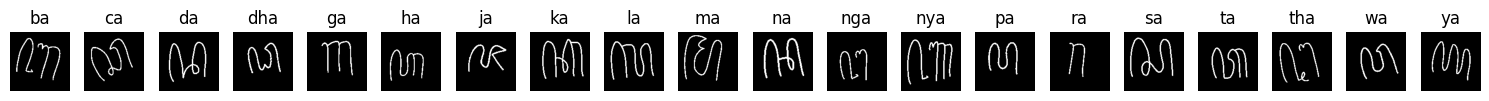

In [ ]:
# Mendapatkan jumlah total gambar dan label unik
total_images = len(images)
total_unique_labels = len(np.unique(labels))

print("Total Gambar: ", total_images)
print("Total Label: ", total_unique_labels)

# Menampilkan contoh gambar dari setiap label
fig, axes = plt.subplots(nrows=1, ncols=total_unique_labels, figsize=(15, 5))

for i, (label, label_images) in enumerate(label_to_images.items()):
    ax = axes[i]
    if len(label_images) > 50:
        ax.imshow(label_images[50], cmap='gray')
        ax.set_title(label)
    else:
        ax.set_title(f"{label}\n(Not enough images)")
    ax.axis('off')

plt.tight_layout()
plt.show()

**Modelling**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


Epoch 1/4
33/33 [==============================] - 38s 1s/step - loss: 15.5902 - accuracy: 0.2185 - val_loss: 7.0718 - val_accuracy: 0.0000e+00
Epoch 2/4
33/33 [==============================] - 33s 1s/step - loss: 0.9355 - accuracy: 0.7286 - val_loss: 10.5861 - val_accuracy: 0.0000e+00
Epoch 3/4
33/33 [==============================] - 35s 1s/step - loss: 0.2784 - accuracy: 0.9153 - val_loss: 16.9456 - val_accuracy: 0.0000e+00
Epoch 4/4
33/33 [==============================] - 32s 987ms/step - loss: 0.1453 - accuracy: 0.9509 - val_loss: 24.7985 - val_accuracy: 0.0000e+00
Training accuracy:  0.9509143233299255


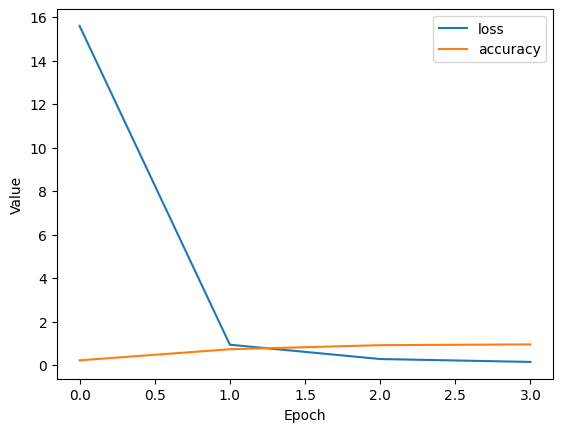

In [ ]:
# Fungsi membangun model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ukuran gambar yang akan digunakan
input_shape = images[0].shape

# jumlah kelas
num_classes = len(label_to_images)

# membangun model
model = build_model(input_shape, num_classes)

# mengkonversi label menjadi bilangan bulat
label_to_index = {label: i for i, label in enumerate(label_to_images)}
labels_index = np.array([label_to_index[label] for label in labels])

# melatih model
history = model.fit(np.array(images), labels_index, epochs=4, batch_size=32, validation_split=0.2)

# menghitung akurasi
accuracy = history.history['accuracy'][-1]
print("Training accuracy: ", accuracy)

# plot loss dan accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import warnings

# menonaktifkan warning untuk pembagian oleh nol
warnings.filterwarnings("ignore", category=RuntimeWarning)

# predict labels for the validation data
predicted_labels = model.predict(np.array(images))
# convert predicted labels to class indices
predicted_indices = np.argmax(predicted_labels, axis=1)
# compute confusion matrix
conf_matrix = confusion_matrix(labels_index, predicted_indices)
# calculate classification metrics
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives
# calculate precision, recall, and f1-score
precision = true_positives /(true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

# handle division by zero
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)

# calculate f1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# handle division by zero in f1-score calculation
f1_score = np.nan_to_num(f1_score, nan=0)

# average metrics across classes
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# calculate accuracy
accuracy = accuracy_score(labels_index, predicted_indices)

# Print classification report
print("Classification Report: ")
print("Accuracy: ", accuracy)
print("Average precision: ", avg_precision)
print("Average Recall: ", avg_recall)
print("Average F1-Score: ", avg_f1_score)

41/41 [==============================] - 12s 286ms/step
Classification Report: 
Accuracy:  0.7821401077752117
Average precision:  0.6457013170322086
Average Recall:  0.7824725274725275
Average F1-Score:  0.7025896641927802


41/41 [==============================] - 10s 246ms/step
Confusion Matrix: 
[[67  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 62  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 62  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 65  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  2  0 60  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 65  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  1  0  0 62  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 65  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 59  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 65  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0 64  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0

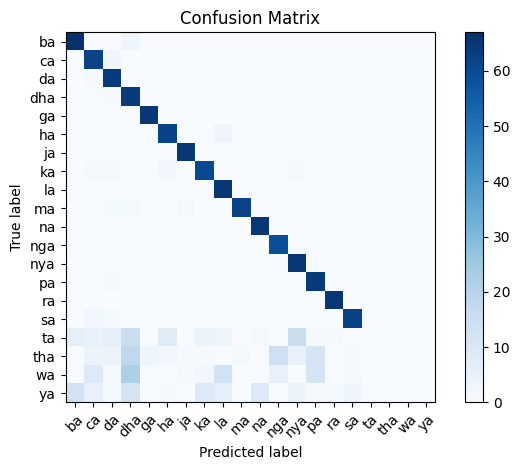

In [ ]:
# memprediksi label untuk data validasi
# memprediksi probabilitas untuk data validasi
predicted_probabilities = model.predict(np.array(images))

# mengambil label dengan probabilitas tertinggi sebagai prediksi
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# membuat confusion matrix
cm = confusion_matrix(labels_index, predicted_labels)

# menampilkan confusion matrix
print("Confusion Matrix: ")
print(cm)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_to_index))
plt.xticks(tick_marks, label_to_index, rotation=45)
plt.yticks(tick_marks, label_to_index)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

**Uji Coba**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fungsi untuk memuat gambar-gambar dan labelnya
def load_images(directory):
    images = []
    filenames = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):  # Pastikan hanya memproses file, bukan direktori
            image = cv2.imread(filepath)
            if image is not None:
                image = cv2.resize(image, (128, 128))

                # Preprocess the image (pastikan proses ini sesuai dengan yang Anda gunakan saat melatih model)
                _, _, negative_adjusted_image = preprocess_image(image)

                # Append the image and filename
                images.append(negative_adjusted_image)
                filenames.append(filename)

    return images, filenames

# Fungsi preprocess_image perlu didefinisikan dengan benar
def preprocess_image(image):
    # Lakukan proses preprocessing yang sesuai dengan data latih model
    # Misalnya, normalisasi, konversi ke grayscale, dll.
    return image

# Direktori tempat gambar tersimpan
predict_dir = '/content/gdrive/MyDrive/testing'

# Memuat gambar dari direktori
predict_images, predict_filenames = load_images(predict_dir)

# Misalkan model dan label_to_index sudah didefinisikan sebelumnya
# Gantilah dengan cara Anda memuat atau mendefinisikan model
# Contoh penggunaan model sequential:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Load weights jika diperlukan
# model.load_weights('path_to_weights.h5')

# Compile model jika diperlukan
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Memprediksi label untuk gambar
predicted_probabilities = model.predict(np.array(predict_images))

# Mengambil label dengan probabilitas tertinggi sebagai prediksi
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Mengkonversi indeks label kembali ke label asli
label_to_index = {0: 'label_0', 1: 'label_1', 2: 'label_2'}  # Ganti dengan label_to_index Anda
index_to_label = {i: label for label, i in label_to_index.items()}
predicted_aksara = [index_to_label[idx] for idx in predicted_labels]

# Menampilkan gambar dan hasil prediksinya
# Mengatur ukuran grid
num_rows = (len(predict_filenames) + 9) // 10
num_cols = min(len(predict_filenames), 10)

# Membuat subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

# Menampilkan gambar dan hasil prediksi
for i, ax in enumerate(axes.flat):
    if i < len(predict_filenames):
        ax.imshow(cv2.cvtColor(predict_images[i], cv2.COLOR_BGR2RGB))
        ax.set_title(f'Predicted aksara: {predicted_aksara[i]}')
        ax.axis('off')
    else:
        ax.axis('off')  # Menghilangkan sumbu untuk gambar yang tidak terpakai

plt.tight_layout()
plt.show()


ValueError: Expected input data to be non-empty.

**Pertanyaan 1 - Data Quantity vs Accuracy**

Epoch 1/4
4/4 [==============================] - 3s 704ms/step - loss: 0.1016 - accuracy: 0.9612 - val_loss: 0.0546 - val_accuracy: 1.0000
Epoch 2/4
4/4 [==============================] - 3s 841ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 3/4
4/4 [==============================] - 5s 1s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 4/4
4/4 [==============================] - 5s 1s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 1/4
7/7 [==============================] - 6s 847ms/step - loss: 0.1317 - accuracy: 0.9710 - val_loss: 0.1623 - val_accuracy: 0.9615
Epoch 2/4
7/7 [==============================] - 8s 1s/step - loss: 0.0357 - accuracy: 0.9855 - val_loss: 0.1951 - val_accuracy: 0.9231
Epoch 3/4
7/7 [==============================] - 6s 846ms/step - loss: 0.0311 - accuracy: 0.9855 - val_loss: 0.1334 - val_accuracy: 0.9808
Epoch 4/4
7/7 [=====================

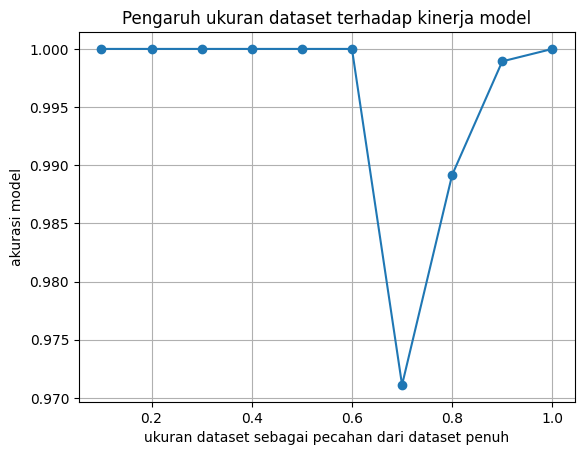

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# fungsi mengonversi label kedalam bentuk numerik
def convert_labels_to_numeric(labels):
  unique_labels = np.unique(labels)
  label_to_index = {label: i for i, label in enumerate(unique_labels)}
  numeric_labels = [label_to_index[label] for label in labels]
  return np.array(numeric_labels)

# melatih model dengan subset dataset tertentu
def train_model_with_subset(images, labels, subset_size, model):
  # ambil subset dataset
  num_samples = int(len(images) * subset_size)
  subset_images = images[:num_samples]
  subset_labels = labels[:num_samples]

  # bagi data menjadi data pelatihan dan data validasi
  x_train, x_val, y_train, y_val = train_test_split(subset_images, subset_labels, test_size=0.2, random_state=42)

  # latih model
  history = model.fit(x_train, y_train, epochs=4, batch_size=32, validation_data=(x_val, y_val))

  # ambil akurasi dari history
  accuracy = history.history['accuracy'][-1]
  return accuracy

# fungsi membagi dataset menjadi subset
def divide_dataset(images, labels, num_subsets):
  subset_sizes = np.linspace(0.1, 1.0, num_subsets) # mulai dari 10% hingga 100% dataset
  accuracies = []

  # lakukan pelatihan utk stiap subset
  for subset_size in subset_sizes:
    # lakukan pelatihan dan evaluasi
    accuracy = train_model_with_subset(images, labels, subset_size, model)
    accuracies.append(accuracy)

  return subset_sizes, accuracies

# contoh penggunaan
num_subsets = 10 # dataset menjadi 10 subset

# memuat gambar ke dalam numpy arrays
images_np = np.array(images)
labels_np = np.array(labels)

# konversi label ke dalam bentuk numerik dan dimuat kedalam numpy arrays
numeric_labels = convert_labels_to_numeric(labels_np)

subset_sizes, accuracies = divide_dataset(images_np, numeric_labels, num_subsets)

# plotting hasil
plt.plot(subset_sizes, accuracies, marker='o')
plt.title('Pengaruh ukuran dataset terhadap kinerja model')
plt.xlabel('ukuran dataset sebagai pecahan dari dataset penuh')
plt.ylabel('akurasi model')
plt.grid(True)
plt.show()
